# Verification problem

Verification of transient solution of 1D rod from the [NAFEMS](https://www.nafems.org) test suite, see section '1D Single Equation' on [wolfram.com](https://reference.wolfram.com/language/PDEModels/tutorial/HeatTransfer/HeatTransferVerificationTests.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from objdict import ObjDict
from functions import *
import scipy.sparse as sp
from FEMesh import readmsh
from scipy.integrate import solve_ivp
from math import *

%load_ext autoreload
%autoreload 2

In [ ]:

#Übungsblatt 9 Aufgabe 2.1
def heatMe(rho, c):
    def computeMe(x):
        u = x[:, 1] - x[:, 0]
        v = x[:, 2] - x[:, 1]
        Ae = abs(1/2 * (u[0]*v[1] - u[1]*v[0]))
        I = np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])
        Me = 1/12 * rho * c * Ae * I
        return Me
    return computeMe

#Übungsblatt 9 Aufgabe 2.2
def assembleKMr(m):
    k = m.elements.shape[1]
    N = m.nodes.shape[1]
    K = np.zeros([N, N])
    M = np.zeros([N, N])
    r = np.zeros([N])

    for n in m.groupNames:
        g = m.groups[n]
        
        for e in range(0, g.Ne):
            Ie = g.elements[:, e]
            xe = m.nodes[:, g.elements[:, e]]
            
            if 'keFunc' in g.p:
                Ke = g.p.keFunc(xe)
                K[np.ix_(Ie, Ie)] += Ke
            if "reFunc" in g.p:    
                re = g.p.reFunc(xe)
                r[Ie] += re
            if "meFunc" in g.p:    
                Me = g.p.meFunc(xe)
                M[np.ix_(Ie, Ie)] += Me

    return K, M, r

## Mesh

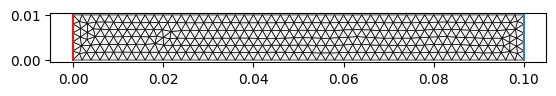

In [2]:
m = readmsh('gmsh/rod.msh')
m.plot()

## Element functions

In [3]:
m.p.keFunc = heatKe(35)
m.p.meFunc = heatMe(7200, 440.5)

## Boundary conditions

We use Robin BCs in order to impose Dirichlet BCs using a large value for the heat transfer coefficient  als penalty parameter.

In [4]:
pen = 1e10
m.groups.bl.p.keFunc = robinKe(pen)
m.groups.bl.p.reFunc = robinRe(pen, 1)
m.groups.br.p.keFunc = robinKe(pen)

## Initial condition

In [5]:
t0 = np.zeros(m.Nn)

### Solve initial value problem

#### ODE function

In [6]:
K, M, r = assembleKMr(m)
invM = np.linalg.inv(M)
invMK = invM @ K

def F(t, thetaHat):
    return invM @ (-K @ thetaHat + 100 * sin(pi * t / 40) * r)

#### Solve initial value problem

Use backward differentiation method with specified Jacobian and maximum timestep size.

In [7]:
sol = solve_ivp(F, [0, 32], t0, method='BDF', jac=-invMK, max_step=30)

## Plot results

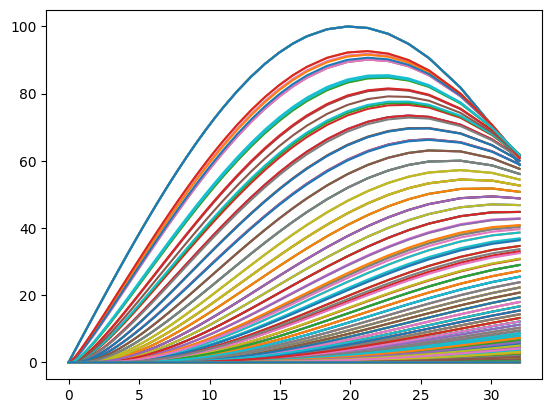

In [8]:
for i in range(0, sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i])


## Compare to reference value

The relative error should be smaller than one permille.

In [9]:
tref = 36.6
tact = sol.y[m.groups.p.nodeIDs[0], -1]
error = abs(tref - tact) / tref

# Print results
print('Temperature:', tact)
print('Relative error:', error)
if error < 1e-3:
    print('Test passed')
else:
    print('Test failed')

Temperature: 36.6272426926979
Relative error: 0.0007443358660627483
Test passed


# Skizze Hausarbeit

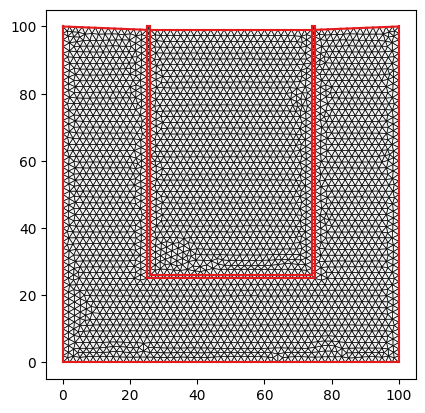

In [10]:
m2 = readmsh('gmsh/prj_ground_sketch.msh')
m2.plot()
